# Breast Cancer Classification & Analysis

This project analyzes the Breast Cancer Wisconsin dataset using classical machine learning techniques.

Goals: 
- Predict whether a tumor is **malignant** or **benign**
- Explore data structure using PCA
- Apply clustering in reduced-dimensional space

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## 1. Dataset Overview

The dataset contains measurements extracted from breast tumor images.
Each row represents one tumor, and features describe geometric and
texture-related properties of cell nuclei.

Target variable:
- diagnosis: M (malignant), B (benign)

In [123]:
# Load dataset
df = pd.read_csv("breast-cancer.csv")

# First rows
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [124]:
df.shape

(569, 32)

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [126]:
# Counts the malignant and benign diagnoses
df["diagnosis"].value_counts()

diagnosis
B    357
M    212
Name: count, dtype: int64

## 2. Data cleaning & preprocessing

- The `id` column does not contain predictive information and is removed.
- The target variable `diagnosis` is encoded as:
  - 1 = malignant
  - 0 = benign
- All remaining features are numerical and suitable for ML models.

In [127]:
# All the columns
df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [128]:
# Drops the id column
df = df.drop(columns=["id"])

In [129]:
# Changes the diagnoses into numeric value: M=1, B=0
df["diagnosis"] = df["diagnosis"].map({"M": 1, "B": 0})

In [130]:
df["diagnosis"].value_counts(), df.head()

(diagnosis
 0    357
 1    212
 Name: count, dtype: int64,
    diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
 0          1        17.99         10.38          122.80     1001.0   
 1          1        20.57         17.77          132.90     1326.0   
 2          1        19.69         21.25          130.00     1203.0   
 3          1        11.42         20.38           77.58      386.1   
 4          1        20.29         14.34          135.10     1297.0   
 
    smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
 0          0.11840           0.27760          0.3001              0.14710   
 1          0.08474           0.07864          0.0869              0.07017   
 2          0.10960           0.15990          0.1974              0.12790   
 3          0.14250           0.28390          0.2414              0.10520   
 4          0.10030           0.13280          0.1980              0.10430   
 
    symmetry_mean  ...  radius_worst  textu

In [131]:
# Target variable: diagnoses
y = df["diagnosis"]

# Feature matrix: all numerical tumor measurements used for prediction
X = df.drop("diagnosis", axis=1)

print(X.shape, y.shape)

(569, 30) (569,)


## 3. Train–test split

The dataset is split into training and test sets.
Stratification is used to preserve the class distribution.

In [132]:
# 80% train, 20% test
train_fraction = 0.8

In [133]:
# Splits X and y data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1 - train_fraction, stratify=y)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (455, 30) (455,)
Test : (114, 30) (114,)


In [134]:
print("Train distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest distribution:")
print(y_test.value_counts(normalize=True))

Train distribution:
diagnosis
0    0.626374
1    0.373626
Name: proportion, dtype: float64

Test distribution:
diagnosis
0    0.631579
1    0.368421
Name: proportion, dtype: float64


## 4. Feature scaling

Features are standardized using StandardScaler.
This is important for models such as SVM and PCA, which are sensitive
to feature scale.

In [135]:
scaler = StandardScaler()

# Fit the scaler ONLY on training data.
# This learns the mean and standard deviation for each feature.
X_train_scaled = scaler.fit_transform(X_train)

# Apply the same scaling to test data.
# NOT fitting again to avoid data leakage.
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape, X_test_scaled.shape)

(455, 30) (114, 30)


In [136]:
# Checks the mean and standard deviation
print("Train mean:", X_train_scaled.mean(axis=0)[:5])
print("Train std):", X_train_scaled.std(axis=0)[:5])

Train mean: [-1.31762733e-16  3.78695854e-16  4.48969311e-16 -1.75683643e-17
  6.34413157e-16]
Train std): [1. 1. 1. 1. 1.]


## 5. Classification with Support Vector Machine (SVM)

An SVM classifier is trained on the standardized features.
Model performance is evaluated using accuracy on the test set.

In [137]:
# Creates and trains the classifier
classifier = SVC()
classifier.fit(X_train_scaled, y_train)

# Predictions for the test data
prediction = classifier.predict(X_test_scaled)

acc = accuracy_score(y_test, prediction)
print("Accuracy:", acc)

Accuracy: 0.956140350877193


## 6. Principal Component Analysis (PCA)

PCA is applied to reduce dimensionality while preserving variance.
The reduced representation is used to:
- Analyze data structure
- Enable clustering and visualization

In [138]:
# Create a PCA object without limiting the number of components yet
pca = PCA()

# Fit PCA only on the scaled training data
pca.fit(X_train_scaled)

,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


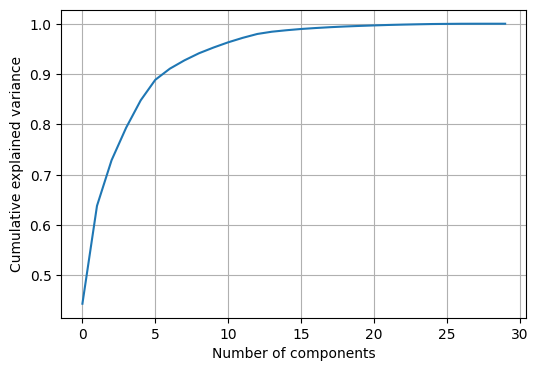

In [139]:
# Cumulative explained variance tells how much of the original information is preserved
# when using the first n principal components
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(6,4))
plt.plot(explained_variance)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid()
plt.show()

In [140]:
# Based on the explained variance curve, I'm selecting 10 components, because they
# preserve over 95% of the original variance
n_components = 10

# Create a new PCA model with the selected number of components
pca = PCA(n_components=n_components)

# Fit PCA on training data and transform it
X_train_pca = pca.fit_transform(X_train_scaled)

# Transform test data using the same PCA model
X_test_pca = pca.transform(X_test_scaled)

print(X_train_pca.shape)
print(X_test_pca.shape)

(455, 10)
(114, 10)


In [141]:
# Train an SVM classifier using the PCA-reduced feature space
classifier_pca = SVC()
classifier_pca.fit(X_train_pca, y_train)

# Prediction
pred_pca = classifier_pca.predict(X_test_pca)

acc_pca = accuracy_score(y_test, pred_pca)
print("Accuracy with PCA:", acc_pca)

Accuracy with PCA: 0.9649122807017544


In [142]:
print("Accuracy without PCA:", acc)
print("Accuracy with PCA:", acc_pca)

Accuracy without PCA: 0.956140350877193
Accuracy with PCA: 0.9649122807017544


## 7. Clustering in PCA space

KMeans clustering (k=2) is applied in PCA space.
Clusters are compared to true diagnosis labels.

Silhouette score is used to evaluate clustering quality.

In [143]:
# Standardize the full feature set before PCA
X_scaled = scaler.fit_transform(X)

In [144]:
# Reduce data to 2 principal components for visualization
pca_visual = PCA(n_components=2)
X_pca_2d = pca_visual.fit_transform(X_scaled)

In [145]:
# Apply KMeans clustering with 2 clusters
# (because expected number of natural groups: benign vs malignant)
kmeans = KMeans(n_clusters=2, random_state=42)

# Assign each sample to a cluster
clusters = kmeans.fit_predict(X_pca_2d)

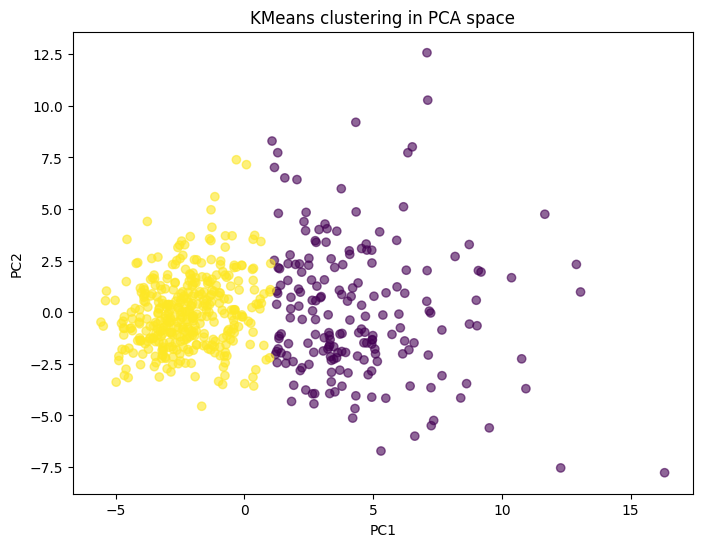

In [146]:
# Visualize KMeans clusters in PCA space
plt.figure(figsize=(8,6))
plt.scatter(
    X_pca_2d[:,0],
    X_pca_2d[:,1],
    c=clusters,
    cmap="viridis",
    alpha=0.6
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans clustering in PCA space")
plt.show()

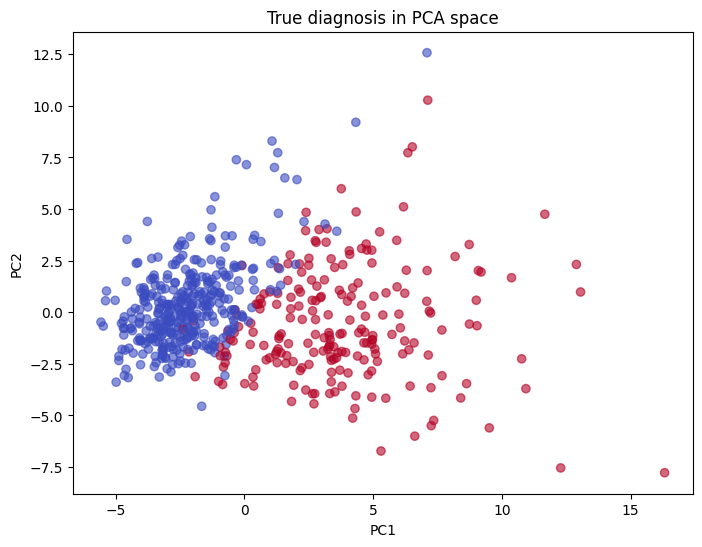

In [147]:
# Visualize true diagnosis labels in the same PCA space
plt.figure(figsize=(8,6))
plt.scatter(
    X_pca_2d[:,0],
    X_pca_2d[:,1],
    c=y,  # true diagnosis
    cmap="coolwarm",
    alpha=0.6
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("True diagnosis in PCA space")
plt.show()

In [148]:
# Evaluate clustering quality using silhouette score
score = silhouette_score(X_pca_2d, clusters)
print("Silhouette score:", score)

Silhouette score: 0.5084690190672025


## 8. Interpretation

In this project, breast tumor measurements were used to predict whether a tumor
is malignant or benign.

- Feature standardization is essential: scaling the data significantly improves the performance and stability of both SVM and PCA.
- PCA successfully reduces the dimensionality of the dataset while preserving most of the original variance.
- Using PCA with 10 components retains nearly the same classification accuracy as the full feature set, indicating that much of the information is redundant.
- SVM performs very well on both the original and PCA-reduced feature spaces, achieving high accuracy with relatively simple model configuration.
- Clustering in PCA space reveals a clear but not perfectly separable structure, which is expected for real-world data.
- The silhouette score (~0.51) suggests meaningful cluster separation with some overlap, highlighting the difference between supervised classification and unsupervised clustering.

Overall, this project shows how preprocessing, dimensionality reduction, classification, and clustering can be combined to analyze and model a real numerical dataset using classical machine learning techniques.